# Flower Recognition CNN Keras

## [ Please upvote / star if you like it ;)  ]

In [222]:
import os
print(os.listdir('Dataset'))

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


## CONTENTS ::

[ **1 ) Importing Various Modules**](#content1)

[ **2 ) Preparing the Data**](#content2)

[ **3 ) Modelling**](#content3)

[ **4 ) Evaluating the Model Performance**](#content4)

[ **5 ) Visualizing Predictons on the Validation Set**](#content5)

<a id="content1"></a>
## 1 ) Importing Various Modules.

In [223]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Configure
# Sets matplotlib to inline and displays graphs below the corresponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

# Model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# Preprocess
from keras.src.legacy.preprocessing.image import ImageDataGenerator

# Deep learning libraries
from keras import backend as K
from keras.src.models.sequential import Sequential
from keras.src.layers.core.dense import Dense
from keras.src.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.src.utils import to_categorical

# Specifically for CNN
from keras.src.layers import Dropout, Flatten,Activation
from keras.src.layers import Conv2D, MaxPooling2D, BatchNormalization

# Specifically for manipulating zipped images and getting numpy arrays of pixel values of images
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

# Set random seeds for reproducibility
import tensorflow as tf
import random as rn

<a id="content2"></a>
## 2 ) Preparing the Data

## 2.1) Making the functions to get the training and validation set from the Images

In [224]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='Dataset\daisy'
FLOWER_SUNFLOWER_DIR='Dataset\sunflower'
FLOWER_TULIP_DIR='Dataset\Tulip'
FLOWER_DANDI_DIR='Dataset\dandelion'
FLOWER_ROSE_DIR='Dataset\Rose'


In [225]:
def assign_label(img,flower_type):
    return flower_type
    

In [226]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))
        
        
        

In [227]:
make_train_data('daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|██████████| 786/786 [00:01<00:00, 641.78it/s]

786


In [228]:
make_train_data('sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 759/759 [00:01<00:00, 508.30it/s]

1545


In [229]:
make_train_data('tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|██████████| 1020/1020 [00:01<00:00, 602.48it/s]

2565


In [230]:
make_train_data('dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|██████████| 1062/1062 [00:01<00:00, 636.21it/s]

3627


In [231]:
make_train_data('rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 875/875 [00:01<00:00, 690.03it/s]

4502


## 2.2 ) Visualizing some Random Images

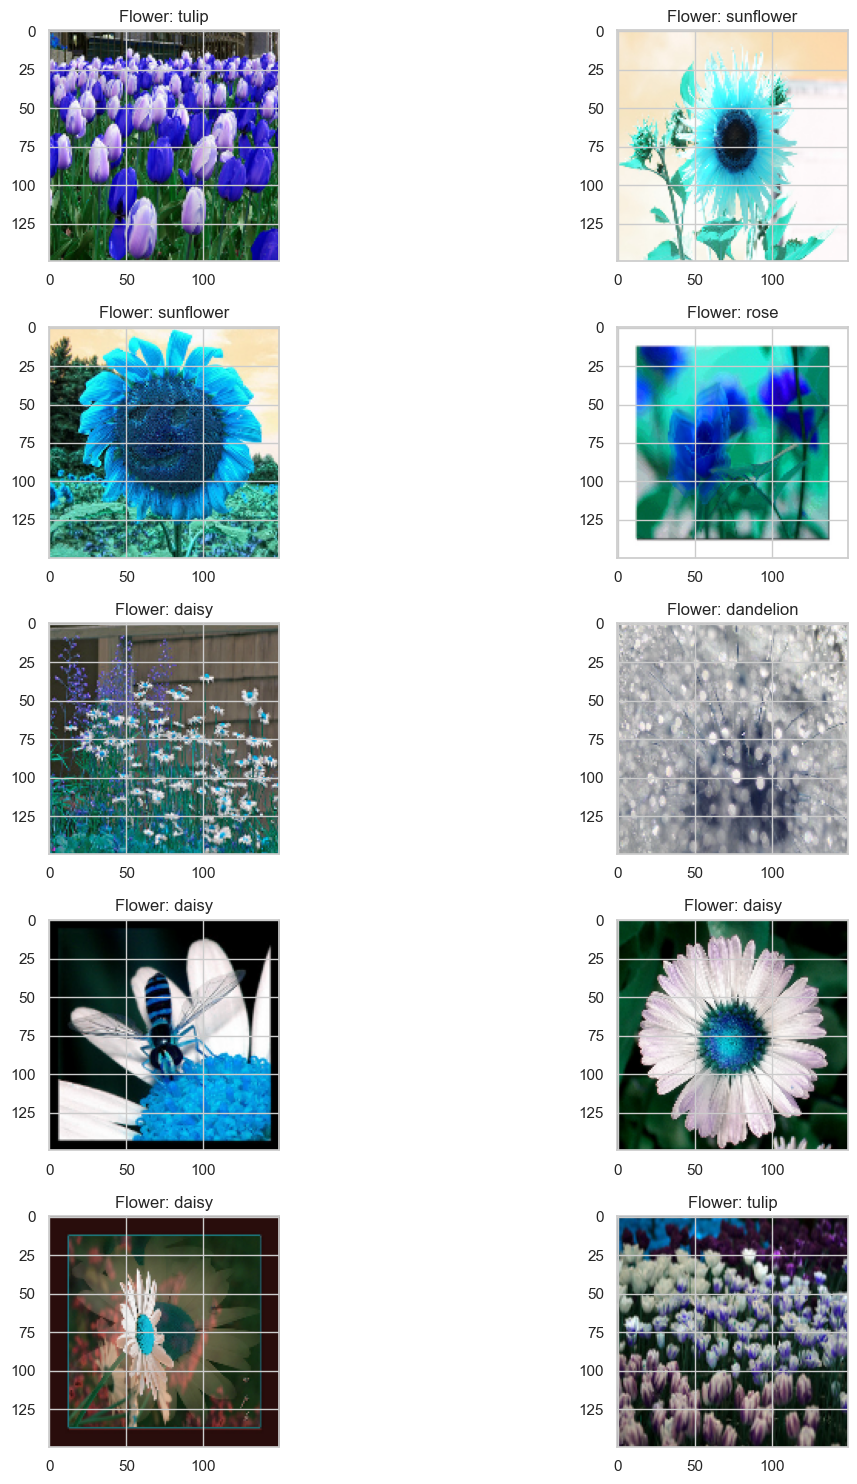

In [232]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()
        

## 2.3 ) Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding

In [233]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

## 2.4 ) Splitting into Training and Validation Sets

In [234]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)


## 2.5 ) Setting the Random Seeds

In [235]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

<a id="content3"></a>
## 3 ) Modelling

## 3.1 ) Building the ConvNet Model

In [236]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

## 3.2 ) Using a LR Annealer

In [237]:
batch_size=128
epochs=50

from keras.src.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

## 3.3 ) Data Augmentation to prevent Overfitting

In [238]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

## 3.4 ) Compiling the Keras Model & Summary

In [239]:
from keras.src.optimizers.adam import Adam

# Definisikan learning rate
learning_rate = 0.001

# Buat objek optimizer Adam dengan learning rate yang sudah diubah
optimizer = Adam(learning_rate=learning_rate)

# Compile model dengan optimizer yang sudah didefinisikan
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [240]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 150, 150, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 37, 37, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 18, 18, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 18, 18, 96)     │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 9, 9, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 7776)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     3,981,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,143,749 (15.81 MB)

 Trainable params: 4,143,749 (15.81 MB)

 Non-trainable params: 0 (0.00 B)

## 3.5 ) Fitting on the Training set and making predcitons on the Validation set

In [241]:
History = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    epochs=epochs, 
                    validation_data=(x_test, y_test),
                    verbose=1, 
                    steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.2941 - loss: 1.4996 - val_accuracy: 0.4973 - val_loss: 1.1701
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.6484 - loss: 1.0801 - val_accuracy: 0.4654 - val_loss: 1.1875
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 851ms/step - accuracy: 0.5055 - loss: 1.1340 - val_accuracy: 0.5426 - val_loss: 1.1335
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.6250 - loss: 1.1271 - val_accuracy: 0.5391 - val_loss: 1.1302
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 837ms/step - accuracy: 0.5449 - loss: 1.0893 - val_accuracy: 0.6004 - val_loss: 0.9923
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.6562 - loss: 0.9764 - val_accuracy: 0.5861 - val_loss: 1.0240
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 830ms/step - accuracy: 0.6052 - loss: 0.9972 - val_accuracy: 0.6155 - val_loss: 0.9680
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.6562 - loss: 0.8336 - val_accuracy: 0.610

<a id="content4"></a>
## 4 ) Evaluating the Model Performance

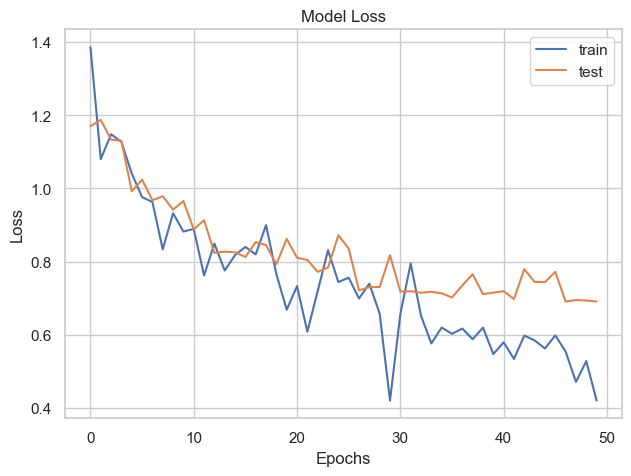

In [242]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

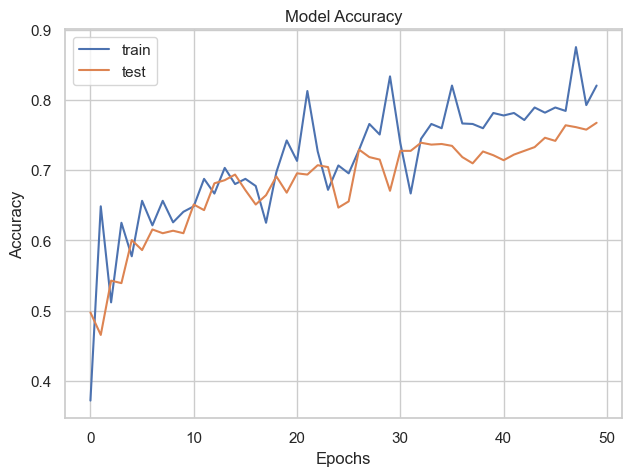

In [244]:
plt.plot(History.history['accuracy'])  # Use 'accuracy' instead of 'acc'
plt.plot(History.history['val_accuracy'])  # Use 'val_accuracy' instead of 'val_acc'
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

<a id="content5"></a>
## 5 ) Visualizing Predictons on the Validation Set

In [245]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step


In [246]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

#### CORRECTLY CLASSIFIED FLOWER IMAGES

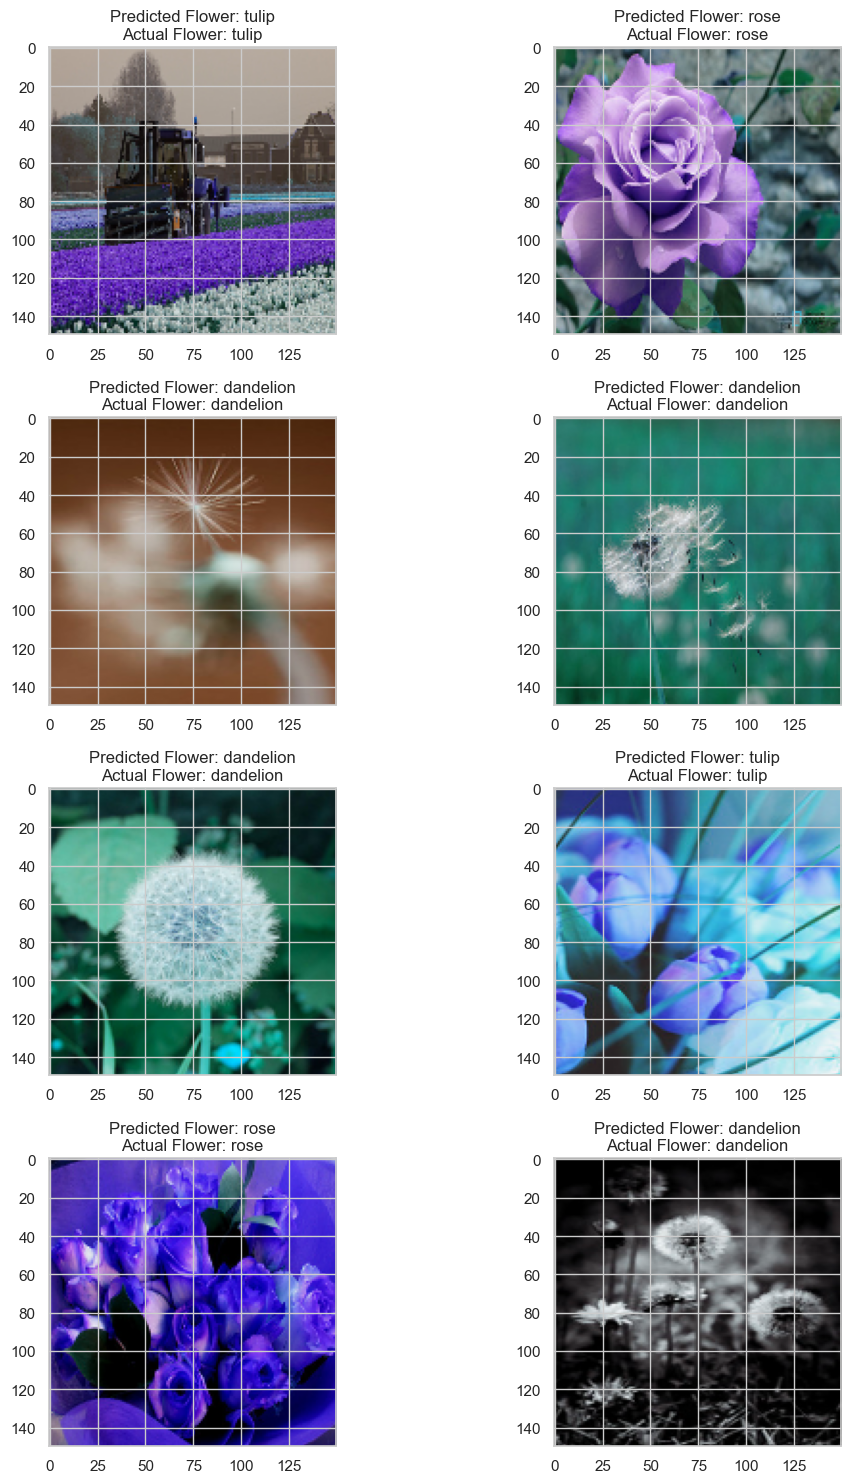

In [248]:
count = 0
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(15, 15)
for i in range(4):
    for j in range(2):
        ax[i,j].imshow(x_test[prop_class[count]])
        pred_flower = le.inverse_transform([pred_digits[prop_class[count]]])[0]
        actual_flower = le.inverse_transform([np.argmax(y_test[prop_class[count]])])[0]
        ax[i,j].set_title(f"Predicted Flower: {pred_flower}\nActual Flower: {actual_flower}")
        plt.tight_layout()
        count += 1


#### MISCLASSIFIED IMAGES OF FLOWERS

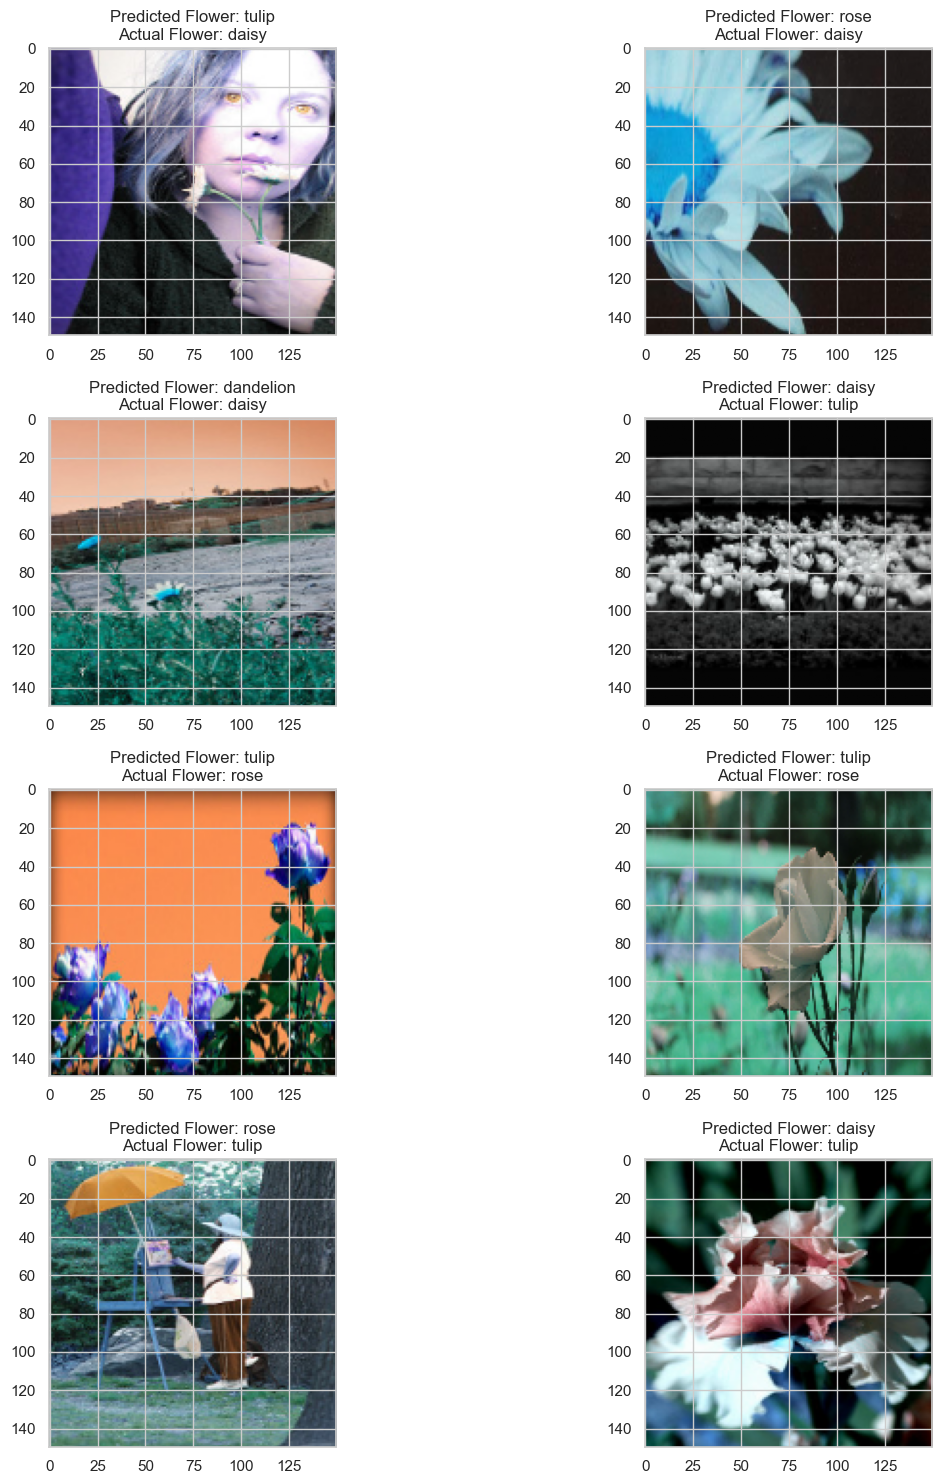

In [262]:
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count = 0
fig, ax = plt.subplots(4, 2, figsize=(15, 15))
ax = ax.flatten()  # Flatten the axis array for easier iteration

for i in range(8):  # Loop over flattened axes
    ax[i].imshow(x_test[mis_class[count]])
    predicted_flower = le.inverse_transform([pred_digits[mis_class[count]]])[0]
    actual_flower = le.inverse_transform([np.argmax(y_test[mis_class[count]])])[0]
    ax[i].set_title(f"Predicted Flower: {predicted_flower}\nActual Flower: {actual_flower}")
    count += 1

fig.tight_layout()
plt.show()
